In [1]:
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb 
import pickle
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
%matplotlib inline

/Users/marenaisabelle/anaconda/envs/dsi/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
# LOAD DATA
chem_lib = pd.read_csv('/Users/marenaisabelle/CODE/GADSI/fulldf')
with open('/Users/marenaisabelle/CODE/GADSI/Capstone/pickle_prints','rb') as f: # Load pickled fingerprints by de-serialize
    fps = pickle.load(f)

In [5]:
# DEFINE PREDICTORS(X= Fingerprints) AND TARGET(Y= Activity)
x = np.asmatrix(fps)
y = chem_lib.Activity.values

In [6]:
# DEFINE CV SCHEME
sss = StratifiedShuffleSplit(y, n_iter=2) # Stratified-Shuffle-Splitto ensure train data preserves class imbalance in cv

In [7]:
# DEFINE PARAMS FOR GRIDSEARCH
params = {
    'objective' : ['binary:logistic'],
    'max_depth' : [4, 8],
    'n_estimators': [250, 500],
    'learning_rate': [0.01, 0.03],
    'subsample': [0.666], # Vary train/test to observe bias/variance tradeoff and class imbalance effects
    'reg_lambda': [0.1, 1], # L2/Ridge Regularization for increased stringency
    'seed' : [1024]
    
}

In [246]:
# DEFINE GRIDSEARCH
gsearch = GridSearchCV(xgb_c, param_grid=params, verbose=2, cv=sss, scoring='roc_auc')
# DEFINE YOUR ESTIMATOR
xgb_c = xgb.XGBClassifier()

In [248]:
# EXECUTE GRIDSEARCH
gsearch.fit(x, y)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=0.1, seed=1024, objective=binary:logistic, max_depth=4 
[CV]  learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=0.1, seed=1024, objective=binary:logistic, max_depth=4 - 2.0min
[CV] learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=0.1, seed=1024, objective=binary:logistic, max_depth=4 
[CV]  learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=0.1, seed=1024, objective=binary:logistic, max_depth=4 - 2.0min
[CV] learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=1, seed=1024, objective=binary:logistic, max_depth=4 
[CV]  learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=1, seed=1024, objective=binary:logistic, max_depth=4 - 2.0min
[CV] learning_rate=0.01, n_estimators=250, subsample=0.666, reg_lambda=1, seed=1024, objective=binary:logistic, max_depth=4 
[CV]  learning_rate=0.01, n_e

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 143.7min finished


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  0. ...,  0.  0.], n_iter=2, test_size=0.1, random_state=None),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.01, 0.03], 'n_estimators': [250, 500], 'subsample': [0.666], 'reg_lambda': [0.1, 1], 'seed': [1024], 'objective': ['binary:logistic'], 'max_depth': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [327]:
# EXTRACT BEST FEATURES TO DEFINE/FIT OPTIMAL XGBLOGREG

print "BEST PARAMS:" , gsearch.best_params_
xgb_best = XGBClassifier()
xgb_best.set_params(**gsearch.best_params_)
xgb_best.fit(X_train, y_train)

BEST PARAMS: {'learning_rate': 0.03, 'n_estimators': 250, 'subsample': 0.666, 'reg_lambda': 0.1, 'seed': 1024, 'objective': 'binary:logistic', 'max_depth': 4}


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.03, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0.1,
       scale_pos_weight=1, seed=1024, silent=True, subsample=0.666)

In [3]:
# DE-SERIALIZE PICKLED XGB LOGISTIC CLASSIFIER
with open('/Users/marenaisabelle/CODE/GADSI/Capstone/OptimalXGB') as fmod:
    xgb_best = pickle.load(fmod)

In [8]:
# TRAIN/TEST EVALUATION
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.333)
pred_prob = xgb_best.predict_proba(X_test)
y_pred = xgb_best.predict(X_test)
frag_importance = xgb_best.feature_importances_
Y_score = xgb_best.score(X_test, y_test)
print "SCORE:", y_score
print "FEATURE IMPORTANCE:", frag_importance
print xgb_best.subsample
print "PREDICTED PROBABILITY:",  pred_prob

SCORE:

NameError: name 'y_score' is not defined

In [2]:
# PLOT ROC
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, confusion_matrix, recall_score, average_precision_score
import matplotlib.pyplot as plt

 TRAIN SIZE: 3486
NUMBER OF TRUE POSITIVES IN TEST:  86
ACCURACY: 0.981927710843
F1: 0.432432432432
RECALL: 0.279069767442
PRECISION: 0.628427597433
CONFUSION MATRIX: [[3399    1]
 [  62   24]]


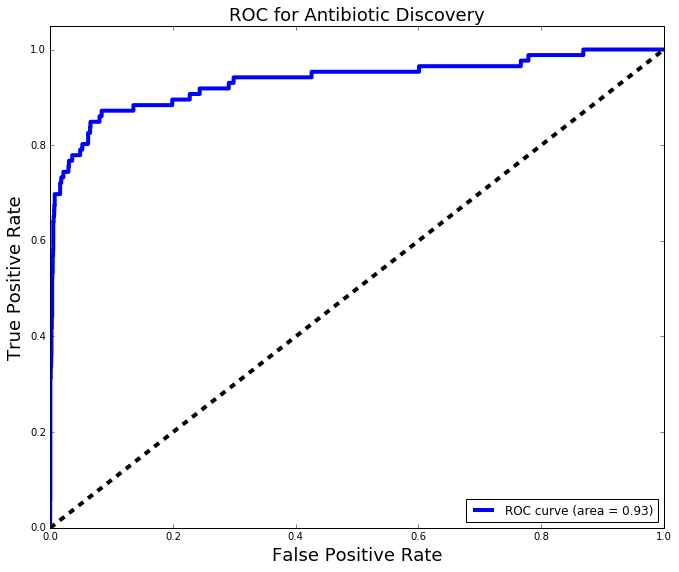

THRESHOLD: 0.90781420, , 0.770039
FALSE POSITIVE RATES [  0.00000000e+00   0.00000000e+00   2.94117647e-04   2.94117647e-04
   2.94117647e-04   2.94117647e-04   8.82352941e-04   8.82352941e-04
   1.17647059e-03   1.47058824e-03   1.76470588e-03   1.76470588e-03
   2.05882353e-03   2.05882353e-03   2.64705882e-03   2.64705882e-03
   3.23529412e-03   3.23529412e-03   3.52941176e-03   3.52941176e-03
   4.11764706e-03   4.11764706e-03   4.70588235e-03   4.70588235e-03
   5.00000000e-03   5.00000000e-03   5.58823529e-03   5.58823529e-03
   6.47058824e-03   6.47058824e-03   6.76470588e-03   6.76470588e-03
   7.35294118e-03   7.35294118e-03   1.61764706e-02   1.61764706e-02
   1.79411765e-02   1.79411765e-02   2.14705882e-02   2.14705882e-02
   2.20588235e-02   2.85294118e-02   2.91176471e-02   2.97058824e-02
   2.97058824e-02   3.02941176e-02   3.05882353e-02   3.58823529e-02
   3.58823529e-02   4.14705882e-02   4.20588235e-02   4.88235294e-02
   4.88235294e-02   4.97058824e-02   5.02941176e

In [9]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.333)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

ypred = xgb_best.predict(X_test).tolist()
predprob = xgb_best.predict_proba(X_test)
accuracy = accuracy_score(y_test, ypred)
f1 = f1_score(y_test, ypred)
cmat = confusion_matrix(y_test, ypred)
rec = recall_score(y_test, ypred)
prec = average_precision_score(y_test, ypred)
# Find the area under the curve for "Active Class"
FPR[1], TPR[1], thresholds = roc_curve(y_test, xgb_best.predict_proba(X_test)[:,1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Print major stats
print "TRAIN SIZE:" , len(y_test)
print "NUMBER OF TRUE POSITIVES IN TEST: " , len([x for x in y_test if x != 0])
print "ACCURACY:", accuracy
print "F1:" , f1
print "RECALL:", rec
print "PRECISION:" , prec
print "CONFUSION MATRIX:" , cmat

# Plot of a ROC curve for "Active Class"
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for Antibiotic Discovery', fontsize=18)
plt.legend(loc="lower right")
plt.show()

print "THRESHOLD: %.8f, , %f" % (thresholds[0], thresholds[1])
print "FALSE POSITIVE RATES" , FPR[1]

In [ ]:
# PICKLE OPTIMIZED XGBLOGREG
xgb_opt = xgb_best.fit(X_train, y_train)
with open('OptimalXGB', 'wb') as f:
    pickle.dump(xgb_opt, f)

In [4]:
FPR[1]

NameError: name 'FPR' is not defined